# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega_{surf} + R_{diff,R2} \end{equation*}
## **SODA 3.4.2**

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.30a81a3b1622423f95714932f6c713e6/status,


In [3]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import xmitgcm
import xgcm
from xhistogram.xarray import histogram
from fastjmd95 import jmd95numba
import fastjmd95
import json

In [4]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem(requester_pays=True)
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)

In [5]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

In [6]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [7]:
path = 'pangeo-tmp/stb2145/SODA/datasets/'

transport = xr.open_zarr(gcfs_w_token.get_mapper(path + 'transport_wg.zarr'))
cells = xr.open_zarr(gcfs_w_token.get_mapper(path + 'cells_wg.zarr'))
surf = xr.open_zarr(gcfs_w_token.get_mapper(path + 'surf_terms.zarr'))
totend = xr.open_zarr(gcfs_w_token.get_mapper(path + 'totend.zarr'))

/tmp/ipykernel_1529/839469371.py:3: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  transport = xr.open_zarr(gcfs_w_token.get_mapper(path + 'transport_wg.zarr'))
/tmp/ipykernel_1529/839469371.py:4: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting conso

## <font color='Green'>Slice to WG region</font>

In [8]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [9]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [10]:
ds_wg = ocean.isel(**lat_range, **lon_range)
#ds_wg = ds.isel(**lat_range, **lon_range)

In [11]:
ocean

<xarray.Dataset>
Dimensions:          (time: 1970, yt_ocean: 1070, xt_ocean: 1440, nv: 2, st_ocean: 50, st_edges_ocean: 51, sw_edges_ocean: 51, sw_ocean: 50, yu_ocean: 1070, xu_ocean: 1440)
Coordinates:
  * nv               (nv) float64 1.0 2.0
  * st_edges_ocean   (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean         (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_edges_ocean   (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean         (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * time             (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean         (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.62 79.88
  * xu_ocean         (xu_ocean) float64 -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yt_ocean         (yt_ocean) float64 -80.02 -79.92 -79.81 ... 89.84 89.95
  * yu_ocean         (yu_ocean) float64 -79.97 -79.86 -79.76 ... 89.89 90.0
Data variables: (12/32)
    anompb           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    average_DT       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    evap_heat        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    hflux_cpl        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    ...               ...
    tauy             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    temp             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 1070, 1440), meta=np.ndarray>
    time_bounds      (time, nv) int64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    u                (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 50, 1070, 1440), meta=np.ndarray>
    v                (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 50, 1070, 1440), meta=np.ndarray>
    wt               (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 1070, 1440), meta=np.ndarray>
Attributes:
    filename:   soda3.4.2_5dy_ocean_or_1993_01_04.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      MOM5_SODA_3.4.2

In [12]:
ds_wg

<xarray.Dataset>
Dimensions:          (time: 1970, yt_ocean: 169, xt_ocean: 381, nv: 2, st_ocean: 50, st_edges_ocean: 51, sw_edges_ocean: 51, sw_ocean: 50, yu_ocean: 169, xu_ocean: 381)
Coordinates:
  * nv               (nv) float64 1.0 2.0
  * st_edges_ocean   (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean         (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_edges_ocean   (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean         (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * time             (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean         (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.62 29.88
  * xu_ocean         (xu_ocean) float64 -65.0 -64.75 -64.5 ... 29.5 29.75 30.0
  * yt_ocean         (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.25 -62.14
  * yu_ocean         (yu_ocean) float64 -79.97 -79.86 -79.76 ... -62.2 -62.08
Data variables: (12/32)
    anompb           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 169, 381), meta=np.ndarray>
    average_DT       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    evap_heat        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 169, 381), meta=np.ndarray>
    hflux_cpl        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 169, 381), meta=np.ndarray>
    ...               ...
    tauy             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 169, 381), meta=np.ndarray>
    temp             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
    time_bounds      (time, nv) int64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    u                (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
    v                (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
    wt               (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
Attributes:
    filename:   soda3.4.2_5dy_ocean_or_1993_01_04.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      MOM5_SODA_3.4.2

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [13]:
pref = 2000

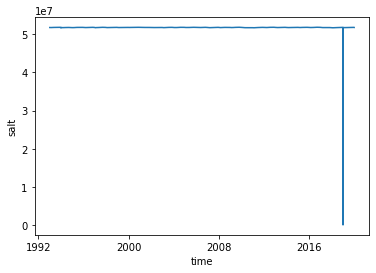

In [14]:
ds_wg.salt.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()

In [15]:
mask = ds_wg.time != ds_wg.time.sel(time='2018-12-24').values
salt_mask = ds_wg.salt.where(mask)#.load()
temp_mask = ds_wg.temp.where(mask)#.load()

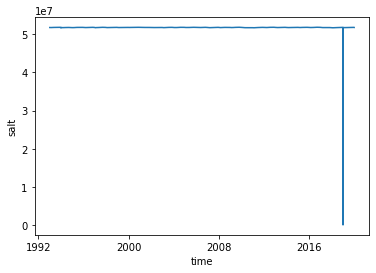

In [16]:
salt_mask.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()
#still shows dip bc of .sum() but mask does work!

In [17]:
#USE THIS!!
sigma2 = fastjmd95.rho(salt_mask, temp_mask, pref)

In [18]:
sigma2

,Array,Chunk
Bytes,47.25 GiB,24.56 MiB
Shape,"(1970, 50, 169, 381)","(1, 50, 169, 381)"
Count,21674 Tasks,1970 Chunks
Type,float64,numpy.ndarray


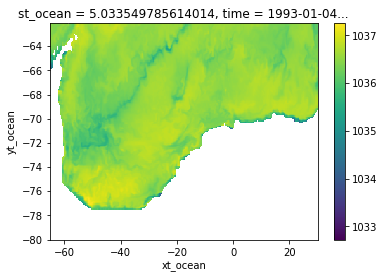

In [24]:
sigma2[0,0].plot()

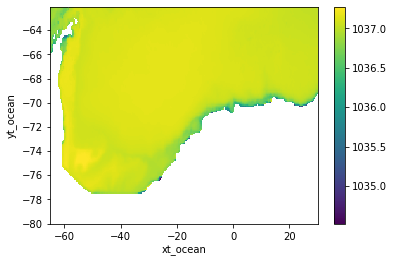

In [25]:
sigma2.mean(dim=['time', 'st_ocean']).plot()

In [26]:
sigma2.nbytes/1e9

50.738532

In [ ]:
sigma2.mean(dim=['time', 'st_ocean']).plot.hist()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

In [19]:
drhodt = fastjmd95.drhodt(salt_mask, temp_mask, pref)
drhods = fastjmd95.drhods(salt_mask, temp_mask, pref)

In [20]:
vol = cells.dx_interp * cells.dy_u * cells.dz

In [21]:
totttend_truth = (totend.totttend * drhodt[1:])# * vol)#.load()

In [22]:
totstend_truth = (totend.totstend * drhods[1:])# * vol)#.load()

In [23]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9
totend_truth = (delta_sigma * vol) / total_time

In [24]:
dt_values = (surf.time.diff('time') / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], 
                  coords={'time': (['time'], surf.time.values[1:])}) #shaves off first time stamp in `surf.time`
surf.coords['dt'] = dt

In [33]:
surf.dt[1:]

<xarray.DataArray 'dt' (time: 1969)>
array([432000., 432000., 432000., ..., 432000., 432000., 432000.],
      dtype=float32)
Coordinates:
  * time     (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
    dt       (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

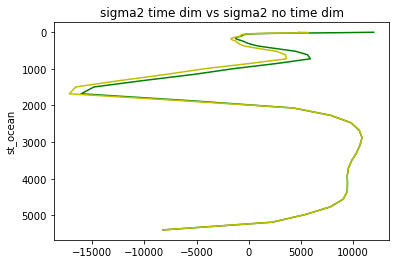

In [36]:
(sigma2.diff(dim='time')*vol/surf.dt[1:]).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim');

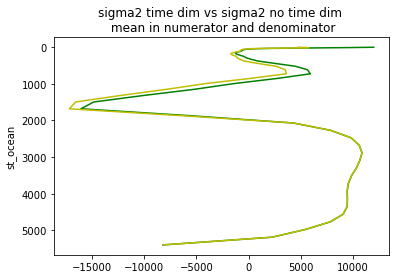

In [37]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, 
                                                                                                               color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim \n mean in numerator and denominator');

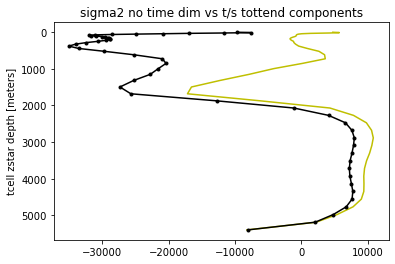

In [38]:
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 no time dim vs t/s tottend components');

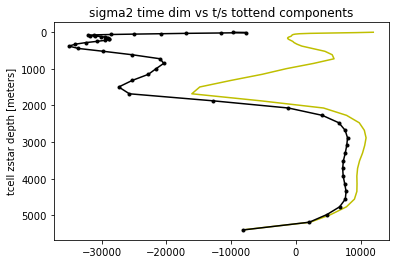

In [39]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', 
                                                                                                               yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 time dim vs t/s tottend components');

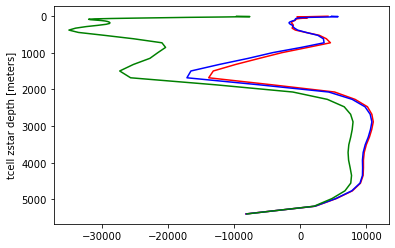

In [24]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', 
                                                                                                               yincrease=False, color='red')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='blue')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green');

In [25]:
totend_truth = ((sigma2.diff(dim='time') * vol) / surf.dt[1:]).drop('dt')#.load()

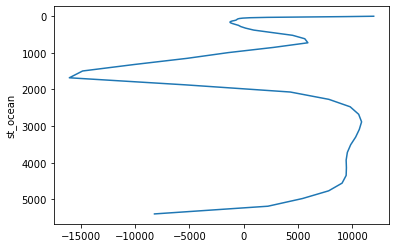

In [26]:
totend_truth.sum(['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

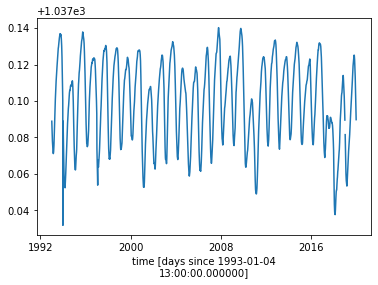

In [101]:
sigma2.mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

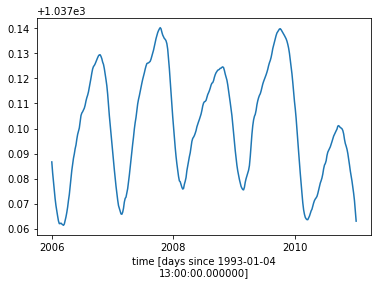

In [105]:
#SOSE time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.sel(time=slice('2006', '2010')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

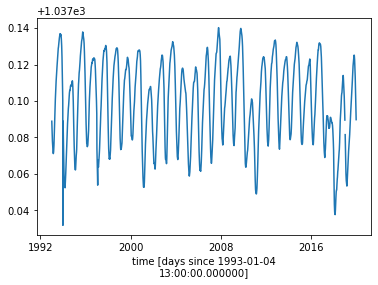

In [106]:
sigma2.sel(time=slice('1980', '2019')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

In [107]:
sigma2.min().values

array(1032.01930673)

In [108]:
sigma2.max().values

array(1039.03267855)

In [46]:
# define bins (ECCO & SOSE bin size 100)
delta_sigma = 3.7e-3
sigma_bins = np.arange(1036.9, 1037.27, delta_sigma)

In [27]:
delta_sigma = 0.01
sigma_bins = np.arange(1032.0, 1039.0, delta_sigma)

In [28]:
sigma_bins.size

700

In [29]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol.fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']).load()

In [30]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 1970, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

(1037.0, 1037.3)

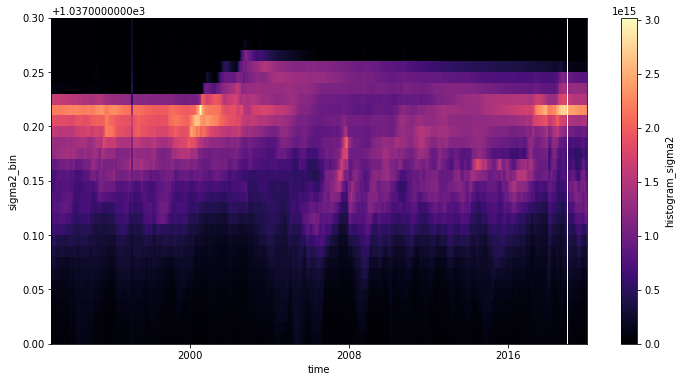

In [31]:
sigma_dist.where(mask).plot(x='time', figsize=(12, 6), cmap='magma')
plt.ylim(1037, 1037.3)

(1037.0, 1037.3)

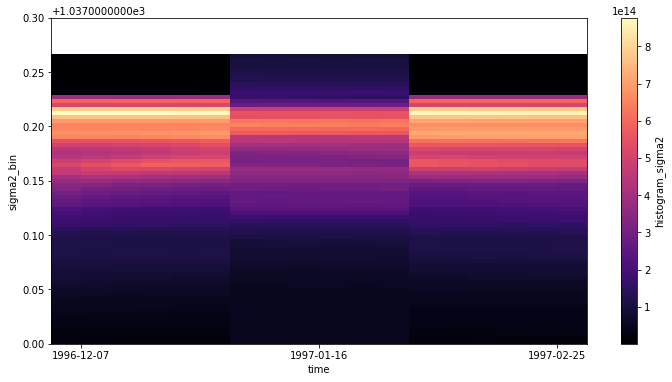

In [51]:
sigma_dist.sel(time=slice('1996-12', '1997-02')).where(mask).plot(x='time', figsize=(12, 6), cmap='magma')
plt.ylim(1037, 1037.3)

(1037.0, 1037.3)

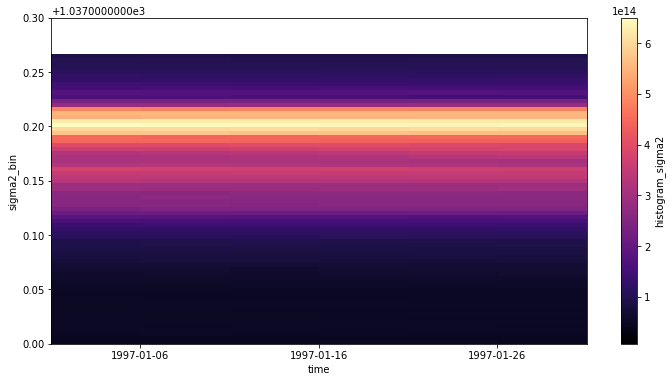

In [52]:
sigma_dist.sel(time=slice('1997-01-03', '1997-01-28')).where(mask).plot(x='time', figsize=(12, 6), cmap='magma')
plt.ylim(1037, 1037.3)

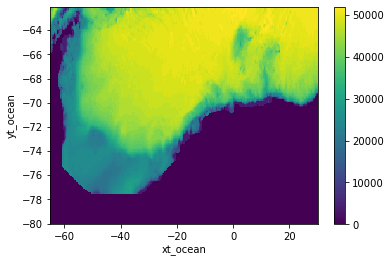

In [53]:
sigma2.sel(time=slice('1997-01-03', '1997-01-28')).sum('st_ocean').mean(dim='time').plot()

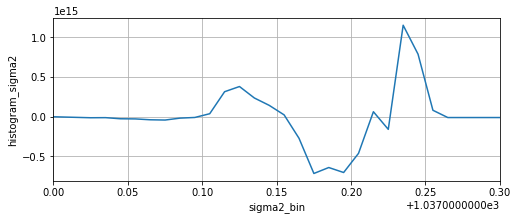

In [35]:
plt.figure(figsize=(8,3))
(sigma_dist[-1] - sigma_dist[0]).plot()
plt.xlim(1037, 1037.3)
plt.grid();

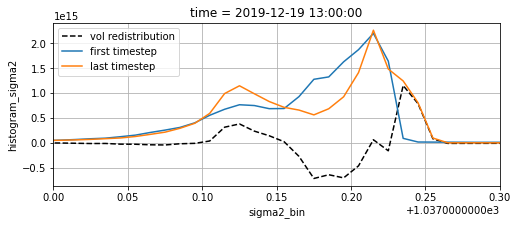

In [34]:
plt.figure(figsize=(8,3))
(sigma_dist[-1] - sigma_dist[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037, 1037.3)
plt.grid();

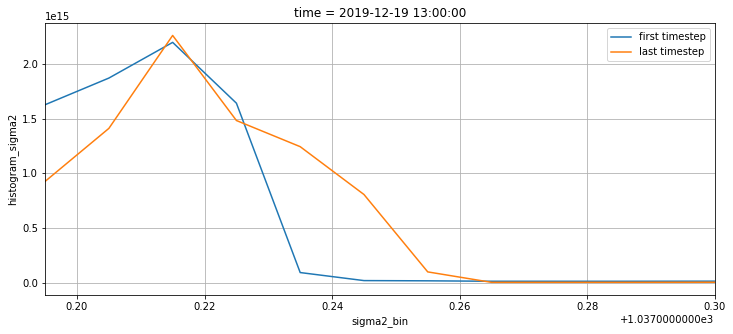

In [36]:
plt.figure(figsize=(12,5))
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.195, 1037.3)
plt.grid();

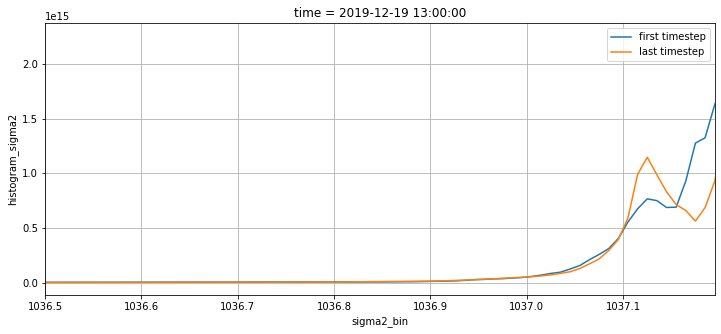

In [37]:
plt.figure(figsize=(12,5))
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.5, 1037.195)
plt.grid();

In [38]:
bottom_vol = (sigma_dist.mean('time').isel(sigma2_bin=-1) - sigma_dist.mean('time').sel(sigma2_bin=1037.195, method='nearest'))/1e6

In [39]:
deep_vol = (sigma_dist.mean('time').sel(sigma2_bin=1037.195, method='nearest') - 
            sigma_dist.mean('time').isel(sigma2_bin=0))/1e6

In [40]:
bottom_vol

<xarray.DataArray 'histogram_sigma2' ()>
array(-1.37256948e+09)

In [41]:
deep_vol

<xarray.DataArray 'histogram_sigma2' ()>
array(1.37256948e+09)

In [42]:
bottom_vol + deep_vol

<xarray.DataArray 'histogram_sigma2' ()>
array(2.31636405)

In [ ]:
-1.37256948e+09

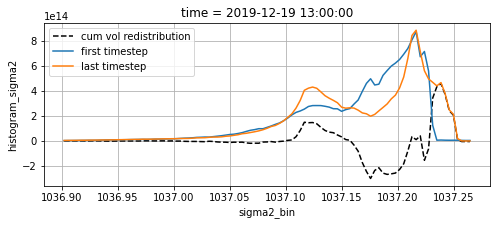

In [56]:
plt.figure(figsize=(8,3))
(sigma_dist[-1] - sigma_dist[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
#plt.xlim(1037, 1037.3)
plt.grid();

#### Need to redescribe after changing sigma bin range and size

- 1037.0-1037.08: volume is lost (2nd plot), negative lobe meaning volume is decreasing (1st plot, black dash), 

- 1037.10-1037.16: volume is added (2nd plot), positive lobe meaning volume is increasing (1st plot, black dash), negative slope for majority of this interval, meaning the rate of volume redistribution is decreasing so therefore, more water buildup of waters in this range bc of less distribution of the waters (that’s why you see more volume in “last timestep” and positive lobe in 1st plot). 

- 1037.16-1037.22: volume is lost (2nd plot), negative lobe meaning volume is decreasing (1st plot, black dash), first half of this interval is negative slope (1st plot) but since it's a negative lobe this negative slope means the vol redistribution is increasing (that's why there's a larger gap in first half of this interval (2nd plot) than the second half which is associated with a positive slope (still in negative lobe) so that means decrease in redistribution rate of cum vol.

- 1037.22-1037.26: volume is added (2nd plot), positive lobe meaning volume is increasing (1st plot, black dash), mostly negative slope meaning decreased rate of volume redistribution meaning waters in this range are being distributed at a slower rate (that’s why you see more volume in “last timestep” and positive lobe in 1st plot).

## <font color='Green'>\begin{equation*} \frac{\partial \mathcal{V}}{\partial t} \end{equation*}</font>

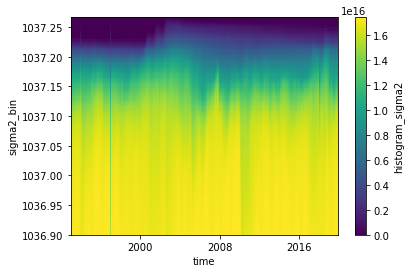

In [58]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.where(mask).transpose().plot()
#plt.ylim(1037.5, 1036.4)

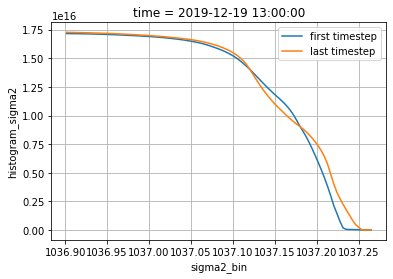

In [59]:
#waters up to 1037.18 lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
#plt.xlim(1037, 1037.3)
plt.grid();

In [60]:
delta_V = V.diff(dim='time')

In [61]:
dVdt = (delta_V / surf.dt[1:]).drop('dt')

In [62]:
dVdt

<xarray.DataArray (time: 1969, sigma2_bin: 99)>
array([[  -411262.59213985,   -425822.20723206,   -564003.12094431, ...,
           663990.56652315,    297158.02159722,    159950.79768056],
       [    99692.46383874,    276638.82332594,    720925.94133491, ...,
         -8473372.74343519,  -8649551.19619907,  -9475268.59822685],
       [   579915.42585062,    581700.33167159,    186294.47927994, ...,
        -10194750.87487963,  -9936300.72846296,  -9608372.82528241],
       ...,
       [    48290.14331372,     82481.35930705,   -260226.92171568, ...,
        -38444830.82217129, -38945373.72615278, -38579102.07864815],
       [    86948.89003736,   -209220.10009339,   -157856.5316712 , ...,
        -29784916.35470833, -29262324.36035185, -29422325.06846296],
       [  -199968.01576157,   -158148.83192756,     67502.25973645, ...,
        -25482846.59393981, -25003956.78489815, -25236396.69803241]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

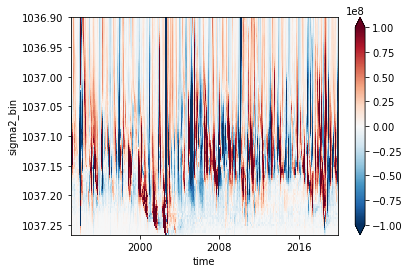

In [66]:
dVdt.where(mask).plot(x='time', vmax=1e8, yincrease=False)
#plt.ylim(1036, 1037.3)

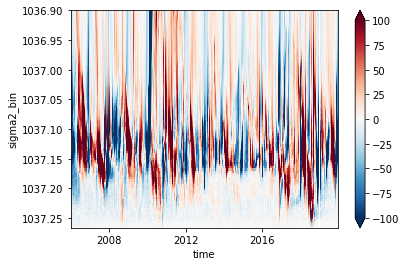

In [69]:
#SOSE time period
(dVdt.where(mask)/1e6).sel(time=slice('2006', '2019')).plot(x='time', vmax=1e2, yincrease=False)
#plt.ylim(1036, 1037.3)

## <font color='Green'>\begin{equation*} \Psi_{vel} = \vec{\textbf{u}} \cdot \nabla \sigma_2 \end{equation*}</font>

In [70]:
grid_transport = xgcm.Grid(transport, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                              'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                              'T': {'center': 'time'},
                                              'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                              'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_transport

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

In [71]:
u_transport_right = (transport.tx_trans).isel(xu_ocean=-1)#.load()
u_transport_left = (transport.tx_trans).isel(xu_ocean=0)#.load()

v_transport = (transport.ty_trans).isel(yu_ocean=-1)#.load()

In [72]:
# BEST WAY TO DO IT
u_transport_mean_value = (u_transport_right.fillna(0.).sum(dim=['yt_ocean', 'st_ocean']) -
                          u_transport_left.fillna(0.).sum(dim=['yt_ocean', 'st_ocean'])).mean(dim='time')
u_transport_mean_value.load()

<xarray.DataArray 'tx_trans' ()>
array(-38.79175, dtype=float32)

In [73]:
v_transport_mean_value = (v_transport).fillna(0.).sum(dim=['xt_ocean', 'st_ocean']).mean(dim='time')
v_transport_mean_value.load()

<xarray.DataArray 'ty_trans' ()>
array(38.92792, dtype=float32)
Coordinates:
    yu_ocean  float64 -62.08

In [74]:
residual = u_transport_mean_value + v_transport_mean_value #+ surf_transport_mean_value
float(residual)

0.13616943359375

In [75]:
def interp_right_with_land(array, wet_mask):
    # there are several different ways to implement this; this is one
    
    data = wet_mask * np.nan_to_num(array)  # zeros the data on land
    data_shift = np.roll(data, 1, -1)
    
    wet_fac = wet_mask + np.roll(wet_mask, 1, -1)
    # wet_fac = 0: water on left AND right
    # wet_fac = 1: water on left OR right
    # wet_fac = 2: no land nearby
    
    # division by zero creates NaNs
    out =  1 / wet_fac * (data + data_shift)
    
    return np.nan_to_num(out)

In [76]:
wet_mask_full = sigma2.notnull().astype(np.int8)
wet_mask_full

,Array,Chunk
Bytes,5.91 GiB,3.07 MiB
Shape,"(1970, 50, 169, 381)","(1, 50, 169, 381)"
Count,27584 Tasks,1970 Chunks
Type,int8,numpy.ndarray


In [77]:
sigma_at_tx_full = xr.apply_ufunc(
    interp_right_with_land,
    sigma2,
    wet_mask_full,
    dask='parallelized',
    input_core_dims=[['yt_ocean', 'xt_ocean'], ['yt_ocean', 'xt_ocean']],
    output_core_dims=[['yt_ocean', 'xu_ocean']],
    dask_gufunc_kwargs=dict(output_sizes={'xu_ocean': transport.dims['xu_ocean']}),
    output_dtypes=[sigma2.dtype],
).assign_coords(xu_ocean=transport.xu_ocean)

sigma_at_ty_full = xr.apply_ufunc(
    interp_right_with_land,
    sigma2,
    wet_mask_full,
    dask='parallelized',
    input_core_dims=[['yt_ocean', 'xt_ocean'], ['yt_ocean', 'xt_ocean']],
    output_core_dims=[['yu_ocean', 'xt_ocean']],
    dask_gufunc_kwargs=dict(output_sizes={'yu_ocean': transport.dims['yu_ocean']}),
    output_dtypes=[sigma2.dtype],
).assign_coords(yu_ocean=transport.yu_ocean)


In [78]:
sigma_at_tx_full.equals(sigma_at_tx_full.where(sigma_at_tx_full.notnull()))

True

In [79]:
sigma_at_ty_full.equals(sigma_at_ty_full.where(sigma_at_ty_full.notnull()))

True

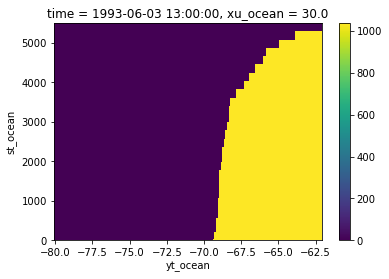

In [80]:
sigma_at_tx_full.isel(xu_ocean=-1)[30].plot()

In [81]:
#interp sigma time dim onto transport time dim
sigma2_u_right_time_interp = sigma_at_tx_full.isel(xu_ocean=-1).interp(time=transport.time)
sigma2_u_left_time_interp = sigma_at_tx_full.isel(xu_ocean=0).interp(time=transport.time)
sigma2_v_time_interp = sigma_at_ty_full.isel(yu_ocean=-1).interp(time=transport.time)

In [82]:
u_transport_right.sum(dim=('yt_ocean', 'st_ocean'))[0].values

array(-9.028181, dtype=float32)

In [83]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma2_u_right_time_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=u_transport_right.fillna(0.), dim=['st_ocean','yt_ocean']).load()
u_binned_left = histogram(sigma2_u_left_time_interp.rename('sigma2'), bins=[sigma_bins],
                          weights=u_transport_left.fillna(0.), dim=['st_ocean','yt_ocean']).load()
v_binned = histogram(sigma2_v_time_interp.rename('sigma2'), bins=[sigma_bins],
                     weights=v_transport.fillna(0.), dim=['st_ocean','xt_ocean']).load()

In [84]:
u_binned_right.sum(dim=('sigma2_bin'))[0].compute()

<xarray.DataArray 'histogram_sigma2' ()>
array(-6.4595866, dtype=float32)
Coordinates:
    time     object 1993-01-07 01:00:00

In [85]:
float((-u_binned_left + u_binned_right + v_binned).sum('sigma2_bin').mean(dim='time'))

-0.6358880996704102

In [86]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right 
             - u_binned_left 
             + v_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 985, sigma2_bin: 99)>
array([[-0.       , -0.       , -0.       , ..., -6.3688617, -6.1177273,
        -6.1689553],
       [-0.       , -0.       , -0.       , ..., -5.652841 , -5.604888 ,
        -5.461024 ],
       [-0.       , -0.       , -0.       , ..., -4.061075 , -4.2316766,
        -4.189076 ],
       ...,
       [-0.       , -0.       , -0.       , ...,  4.1049705,  4.2452908,
         4.3793755],
       [-0.       , -0.       , -0.       , ...,  2.8745213,  3.0164685,
         3.0955822],
       [-0.       , -0.       , -0.       , ...,  1.8256625,  1.9217308,
         1.820172 ]], dtype=float32)
Coordinates:
  * time        (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

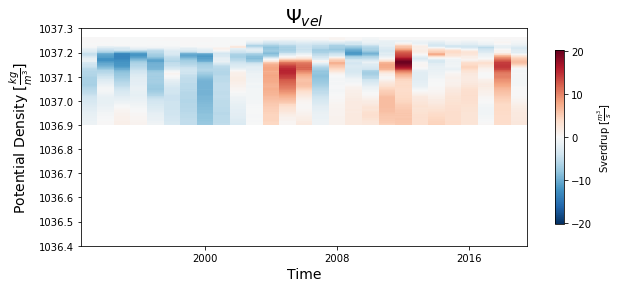

In [87]:
psi_vel.resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4),
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1036.4, 1037.3);

(1036.5, 1037.5)

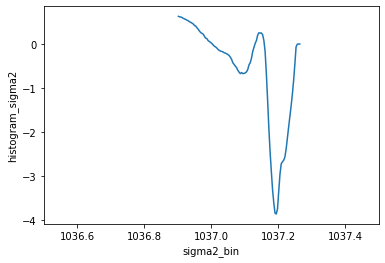

In [88]:
psi_vel.mean(dim='time').plot()
plt.xlim(1036.5, 1037.5)

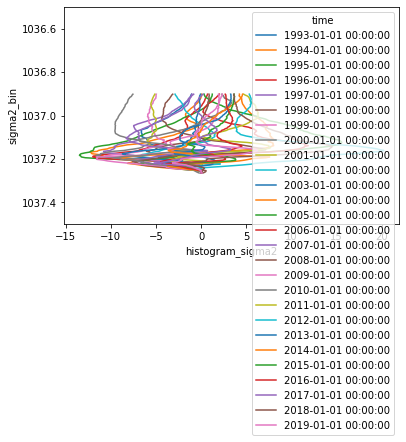

In [89]:
psi_vel.resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin');#, add_legend=True)
plt.ylim(1037.5, 1036.5);

# <font color='Green'>\begin{equation*} \Omega_{trans} = \frac{\partial V}{\partial t} - \Psi_{vel}\end{equation*} </font>

In [90]:
#omega_tot_interp = omega_total.interp(time=psi_vel.time)
#R1_interp = R1.interp(time=psi_vel.time)
dVdt_interp = dVdt.interp(time=psi_vel.time)

In [91]:
omega_trans = (dVdt_interp/1e6) - psi_vel

In [92]:
omega_trans.load()

<xarray.DataArray (time: 985, sigma2_bin: 99)>
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [  0.33980394,   0.42916958,   0.45361021, ...,  -3.68122072,
         -3.688038  ,  -4.0807969 ],
       [ -0.30123275,  -0.2154903 ,  -0.24204669, ..., -11.25363976,
        -10.77831672, -10.26453853],
       ...,
       [ -0.04646868,  -0.05649333,  -0.08354405, ..., -32.65144825,
        -32.30308689, -32.18047379],
       [ -0.04320924,  -0.12784202,  -0.30322512, ..., -35.00692133,
        -35.04720416, -34.73587635],
       [ -0.05650956,  -0.18368447,  -0.04517714, ..., -29.45954397,
        -29.05487133, -29.14953284]])
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{vel} + \Omega_{trans} \end{equation*} </font>

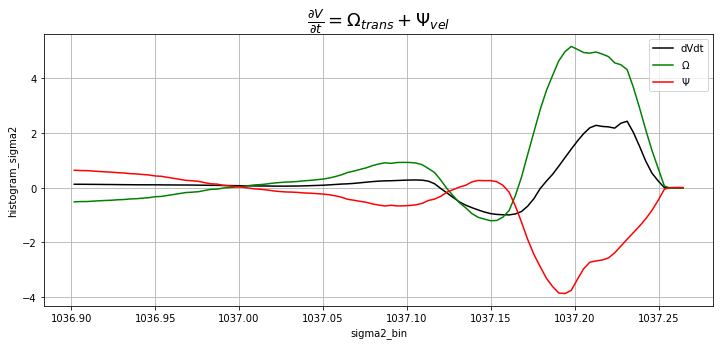

In [94]:
plt.figure(figsize=(12,5))
#(omega_tot_interp/1e6).mean(dim='time').plot(label='tottend', color='k')
(dVdt_interp/1e6).mean(dim='time').plot(label='dVdt', color='k')
omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
#R2.mean(dim='time').plot(label='R2', color='lightgreen')
psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
#(R1_interp/1e6).mean(dim='time').plot(label='R1', color='blue', linestyle='dashed')
plt.grid()
plt.legend()
#plt.xlim(1036.5, 1037.5)
plt.title(r'$\frac{\partial V}{\partial t} = \Omega_{trans} + \Psi_{vel}$', fontsize=18);

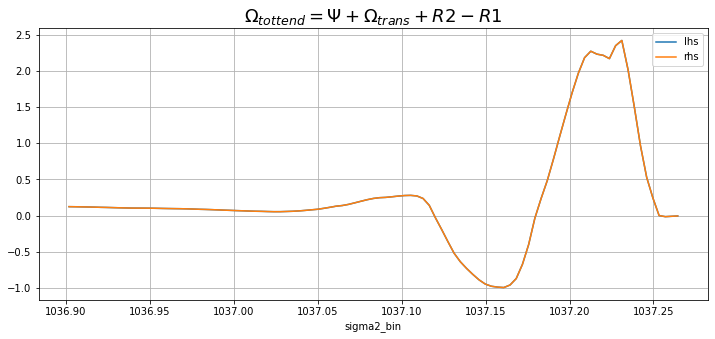

In [95]:
plt.figure(figsize=(12,5))
(dVdt_interp/1e6).mean(dim='time').plot(label='lhs')
(omega_trans + psi_vel).mean(dim='time').plot(label='rhs')
plt.grid()
plt.legend()
#plt.xlim(1036.5, 1037.5)
plt.title(r'$\Omega_{tottend} = \Psi + \Omega_{trans} + R2 - R1$', fontsize=18, fontweight='bold');

## Saving Data

In [96]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [97]:
transport = xr.merge([u_binned_right.rename('u_binned_right'), 
                      u_binned_left.rename('u_binned_left'), 
                      v_binned.rename('v_binned'), psi_vel.rename('psi_vel')])

In [98]:
wmt_budget_terms = xr.merge([dVdt_interp.rename('dVdt'), omega_trans.rename('omega_trans'), transport])

In [99]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:         (sigma2_bin: 99, time: 985)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time            (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 nan nan ... -1.837e+05 -5.651e+04
    omega_trans     (time, sigma2_bin) float64 nan nan nan ... -0.1837 -0.05651
    u_binned_right  (time, sigma2_bin) float32 -0.02889 -0.06877 ... 0.0 0.0
    u_binned_left   (time, sigma2_bin) float32 -0.09437 0.0001839 ... 0.0 0.0
    v_binned        (time, sigma2_bin) float32 -0.01425 -0.1822 ... 0.0 0.0
    psi_vel         (time, sigma2_bin) float32 -6.169 -6.118 ... -0.0 -0.0

In [100]:
#uploading wmt budget terms
gcsmap_wmt_budget_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms_newbins.zarr')
wmt_budget_terms.to_zarr(gcsmap_wmt_budget_terms, mode='w')